# Lab 8: Bayesian and Frequentist Takes on Multi-Armed Bandits {-}
Welcome to the eighth DS102 lab! 

The goals of this lab is to implement and gain a better understanding of the pros and cons of the Upper Confidence Bounds (UCB) and Thompson Sampling algorithms for the multi-armed bandits problem.

The code you need to write is commented out with a message "TODO: fill in". There is additional documentation for each part as you go along.

In preparation for this lab we would recommend that you go over the [lecture notes](http://data102.datahub.berkeley.edu/hub/user-redirect/git-sync?repo=https://github.com/ds-102/sp21&subPath=lecture/lecture18/bandits_notes.ipynb).

## Collaboration Policy {-}
Data science is a collaborative activity. While you may talk with others about the labs, we ask that you **write your solutions individually**. If you do discuss the assignments with others please **include their names** in the cell below.

## Gradescope Submission {-}
To submit this assignment, rerun the notebook from scratch (by selecting Kernel > Restart & Run all), and then print as a pdf (File > download as > pdf) and submit it to Gradescope.


**This assignment should be completed and submitted before Sunday, April 04, 2021 at 11:59 PM. PST**


## Collaborators {-}
Write the names of your collaborators in this cell.

`<Collaborator Name> <Collaborator e-mail>`

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from matplotlib.widgets import Button, CheckButtons
from matplotlib import gridspec
import functools
from Bandit_env import BanditEnv, Interactive_UCB_Algorithm,Interactive_TS_Algorithm

%load_ext autoreload
%autoreload 2
%matplotlib notebook

# 0. Review - Concentration Inequalities

Let $X = \sum_{i=1}^{20} X_i$ where $X_1,\ldots,X_{20}$ are i.i.d. Poisson random variables with parameter $\lambda=1$. Use the following techniques to upper bound $\mathbb{P}(X \geq 26).$

## 0a) Markov's Inequality

...

## 0b) Chebyshev's Inequality

...

## 0c) Chernoff Bound

...

**Solution**: A property of the Poisson random variables is that if $Y_1$, $Y_2$ are independent and are Poisson random variables with parameters $\lambda_1$, $\lambda_2$, then $Y = Y_1 + Y_2$ is a Poisson random variable with parameter $\lambda_1 + \lambda_2$. Therefore, X is a Poisson random variable with parameter $\lambda = 20$. 

Thus, $\mathbb{E}[X] = 20$ and $Var[X] = 20$.

\begin{align}
\forall s > 0, \mathbb{E}[\text{exp}(sX)] &= \sum_{n = 0}^{\infty} \frac{\lambda^{n} \text{exp}(-\lambda)}{n!} \text{exp}(sn) \\
                                          &= \text{exp}(-\lambda) \sum_{n = 0}^{\infty} \frac{(\lambda \text{exp}(s))^{n}}{n!} \\
                                          &= \text{exp}(-\lambda) \text{exp}(\lambda \text{exp}(s)) \\
                                          &= \text{exp}(\lambda (\text{exp}(s) - 1)) \\
                                          &= \text{exp}(20 (\text{exp}(s) - 1))
\end{align}

**a) Markov's Inequality**: $\mathbb{P}(X \geq a) \leq \frac{\mathbb{E}[X]}{a}$ for all $a > 0$. 

So, $\mathbb{P}(X \geq 26) \leq \frac{20}{26} \approx 0.769$.

**b) Chebyshev's Inequality**: $\mathbb{P}(|X - \mathbb{E}(X)| \geq c) \leq \frac{Var[X]}{c^2}$.

So, $\mathbb{P}(|X - 20| \geq 6) \leq \frac{20}{36} \approx 0.5556$

Note: $\mathbb{P}(X \geq 26) \leq \mathbb{P}(X \geq 26) + \mathbb{P}(X \leq 14) = \mathbb{P}(|X - 20| \geq 6)$

**c) Chernoff Bound**: $\mathbb{P}(X \geq a) = \mathbb{P}(e^{tX} \geq e^{ta}) \leq \frac{\mathbb{E}[e^{tX}]}{e^{ta}}$ for all $t > 0$.

So, $\mathbb{P}(X \geq 26) \leq \text{min}_{s \geq 0} \space e^{-26s} e^{20 (e^s - 1)} = \text{min}_{s \geq 0} \space e^{-26s + 20e^s} e^{-20}$. 

To minimize this, we only have to minimize $-26s + 20e^s$. Taking the derivative and setting equal to $0$, we get $s = \text{ln} \frac{26}{20} \approx 0.26236$. Plugging this value of $s$ in, we get $\mathbb{P}(X \geq 26) \leq \text{min}_{s \geq 0} \space e^{-26s} e^{20 (e^s - 1)} \approx 0.4398$.

# Multi-Armed Bandits (MAB) {-}

In this lab we will be implementing two of the most common approaches to solving stochastic Multi-Armed Bandit (MAB) problems. We first define the problem and then you will have a chance to implement the Upper Confidence Bound (UCB) algorithm and the Thompson Sampling (TS) algorithm from lecture and analyze their performance.

Refer to Section 2 of the [lecture notes](http://data102.datahub.berkeley.edu/hub/user-redirect/git-sync?repo=https://github.com/ds-102/sp21&subPath=lecture/lecture18/bandits_notes.ipynb) for all definitions. Note also that to help with book-keeping, we will adopt the expanded notation for rewards developed at the start of Section 6: We assume an $n\times K$ matrix $X$ of *potential* rewards, where all entries are independent, and $X_{ij} \sim P_j$ for each $i$ and $j$ (i.e. the entries in column $j$ are drawn from the reward distribution for arm $j$.) Note that we recover the old model by setting the observered reward at time $t$, $X_t$, to be equal to $X_{T_{A_t}(t),A_t}$ under this new notation. In other words if arm $a$ is pulled at step $t$, then the reward revealed is the earliest entry in the $a$-th column that has yet to be revealed thus far.

### Lab setup: {-}
In this lab, the MAB environment will have a set of arms numbered $0,1,...,K-1$. Each arm $a=0,1,...,K-1$ is associated with a Gaussian reward distribution with mean $\mu_a$ and standard deviation of $\sigma_a=1.5$. To be able to analyze the various algorithms, the optimal arm $a^\ast$ will always be arm $0$, and its mean will always be $\mu^\ast=10$.

By running the following cells, you can interact with a MAB instance of the type we will be using in this lab. You can see the reward distributions as well as the expected cumulative regret you incur when pulling each arm. 

Verify for yourself that explore-then-commit strategies can get stuck pulling the wrong arm.


In [2]:
# Run this cell to initialize the parameters for the arms that we will be pulling from.

# Mean reward for each arm. Arm 0 has the highest mean, but the algorithm doesn't know that yet.
means=[10,9,8,7,6,4]

# Variance of the reward for each arm.
variance=1.5
standard_deviations=[np.sqrt(variance) for arm in range(len(means))]

# Initialize the interactive environment for pulling arms.
bandit_env=BanditEnv(means,standard_deviations)

<IPython.core.display.Javascript object>


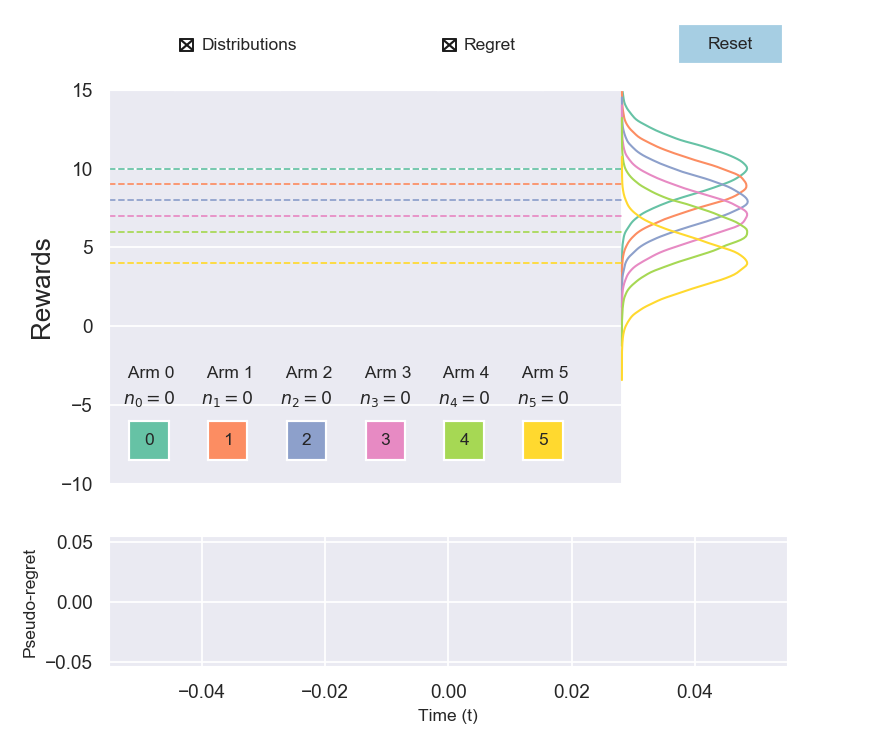

In [3]:
"""
Creates an interactive bandit instance.

    - Pull an arm by clickling on the colored button
    - The true means of the distributions are shown with the dashed horizontal lines
    - Large solid circle is the sample mean of the arm
    - Small empty circle is a sample from the arm
    - The reward distribution of each arm is shown on the right and can be toggled on/off by checking the box
    - Running Pseudo-regret is shown on the bottom and can be toggled on/off by checking the box
"""

# You may need to rerun this cell to restart the gui

%matplotlib notebook
plt.rcParams['figure.figsize']=[7,6]
bandit_env.run_Interactive()

# You can click on the arms to see how it selecting sub-optimal arms accumulates regret

# Question 1.  The Frequentist Approach: Upper Confidence Bound (UCB) {-}

The first algorithm we will analyze is a frequentist take on multi-armed bandits, known as the Upper Confidence Bound (UCB) algorithm. The algorithm was described in the lecture notes, but for convenience we reproduce the definition here, and adapt it to the setting of the lab.

We make an optimistic forecast, called the **upper confidence bound**, for the mean of each arm. More precisely, we set

$$
\text{UCB}_a(t,\delta) = \begin{cases}
\infty & \quad \text{if}~ T_a(t) = 0 \\
\hat{\mu}_a(t) + \sigma_a\sqrt{\frac{2\log(1/\delta)}{T_a(t)}} & \quad \text{otherwise}.
\end{cases}
$$
where
$$\hat{\mu}_a(t) = \frac{1}{T_a(t)}\sum_{i=1}^{T_a(t)} X_{i,a}.$$

The **UCB algorithm** is defined by iteratively making the arm selection:
$$A_{t}= \underset{a \in \{ 0,1,...,K-1\}}{\operatorname{argmax}} \text{UCB}_a(t-1,\delta_t).$$

We set $\delta_t = 1/t^3$.


For each arm $a \in \{ 0,1,...,K-1\}$, you hence need to keep track of:

1. $T_a(t)$: the number of times arm $a$ has been pulled up to and including iteration $t$.
2. $X_{1,a},\ldots,X_{T_a(t),a}$: the samples you have received from arm $a$. 

## 1a. Checkpoint

(i) Explain why UCB starts by pulling every arm once.

**Answer:** So that we have an initial guess to start off from, since initially we had no information about any of the arms and thus cannot rank them.

(ii) Applying Hoeffding's inequality for Gaussian random variables, we have that for any $m=1,\ldots, n$, we have

$$ P( \frac{1}{m}\sum_{i=1}^m X_{i,a}-\mu_a \leq -\epsilon) \leq e^{-\frac{m\epsilon^2}{2\sigma_a^2}}.$$

Show that this results in the upper confidence bound on $\mu_a$:

$$P\left(\mu_a <\frac{1}{m}\sum_{i=1}^m X_{i,a} + \sigma_a\sqrt{\frac{2\log(1/\delta)}{m}}\right)> 1-\delta. $$

**Answer:** Rearranging $P\left(\mu_a <\frac{1}{m}\sum_{i=1}^m X_{i,a} + \sigma_a\sqrt{\frac{2\log(1/\delta)}{m}}\right) > 1-\delta$, we get $$P\left(\frac{1}{m}\sum_{i=1}^m X_{i,a} - \mu_a < - \sigma_a\sqrt{\frac{2\log(1/\delta)}{m}}\right) > 1-\delta.$$

Subtracting both sides from $1$, we get:

$$\mathbb{P}\left(\frac{1}{m}\sum_{i=1}^m X_{i,a} - \mu_a \leq - \sigma_a\sqrt{\frac{2\log(1/\delta)}{m}} \right) < \delta$$

Applying Hoeffding's inequality:

$$\mathbb{P}\left(\frac{1}{m}\sum_{i=1}^m X_{i,a} - \mu_a \leq - \sigma_a\sqrt{\frac{2\log(1/\delta)}{m}} \right) \leq e^{-\frac{m[- \sigma_a\sqrt{\frac{2\log(1/\delta)}{m}}]^{2}}{2\sigma_a^2}} = \delta,$$

which is what we wanted. 

## 1b. UCB Implementation

**`TODO`: Now, use the formula for $A_t$ to fill out the following function which returns the choice of arm as well as the upper confidence bounds of each arm. In the code below, we use the variable "confidence_bound" to refer to the entire term $\hat{\mu}_a(t-1) + \sigma_a\sqrt{\frac{2\log(t^3)}{T_a(t-1)}}$.**

In [4]:
# TODO: complete the function
def UCB_pull_arm(t, standard_deviations, times_pulled, rewards):
    """ Implement the choice of arm for the UCB algorithm
    
    Inputs:
        t : int, current iteration
        standard_deviations : a list of length K (where K is the number of arms) of the 
            standard deviations associates with each arm
        times_pulled: a list of length K (where K is the number of arms) of the number 
            of times each arm has been pulled.
        rewards: a list of K lists. Each of the K lists holds the samples received from
            pulling each arm up to iteration t. 

    Outputs:
        arm: an integer representing the arm that the UCB algorithm would choose.
        confidence_bounds: a list of the confidence bounds for each arm
    """

    K = len(times_pulled) # TODO: fill in
    delta = 1/(t**3)
    
    confidence_bounds=[]
    for arm in range(K):
        # TODO: fill in
        
        if times_pulled[arm]==0:
            confidence_bounds.append(np.inf)
        else:
            confidence_bounds.append(np.mean(rewards[arm])+standard_deviations[arm]*np.sqrt((2/(times_pulled[arm]))*np.log(1/delta)))
        
        # Hint: the \hat\mu_a(t-1) value is the mean of rewards[arm], 
        # and the T_a(t-1) value is equal to times_pulled[arm].
    
    arm = np.argmax(confidence_bounds) # TODO: fill in
    
    return arm, confidence_bounds

In [5]:
# Validation tests, do not modify
K_test = 5
times_pulled_test = [3, 5, 7, 4, 0]
t_test = np.sum(times_pulled_test) + 1
standard_deviations_test = [0.4, 0.2, 0.1, 0.2, 0.5]
rewards_test = [[10.4, 10.6, 11], 
                [8, 13, 12, 11, 9], 
                [9, 10, 10, 8, 9.5, 10.5, 11],
                [8.3, 9.6, 7.9, 8.1],
                []]
test_arm, test_confidence_bounds = UCB_pull_arm(t_test, standard_deviations_test, times_pulled_test, rewards_test)
assert test_arm == 4
assert np.isinf(test_confidence_bounds[-1])
opt_vals = [11.64, 10.98, 9.87, 8.90]
for a in range(K_test-1):
    assert (np.abs(opt_vals[a] - test_confidence_bounds[a]) <= 0.1)
print("Test Passed!")

Test Passed!


Given the function you have filled out, let us investigate the pseudo-regret of the UCB algorithm.  Since the pseudo-regret is an expectation of the regret, the following cell runs the algorithm $20$ times and computes the average pseudo-regret across all runs.

<IPython.core.display.Javascript object>


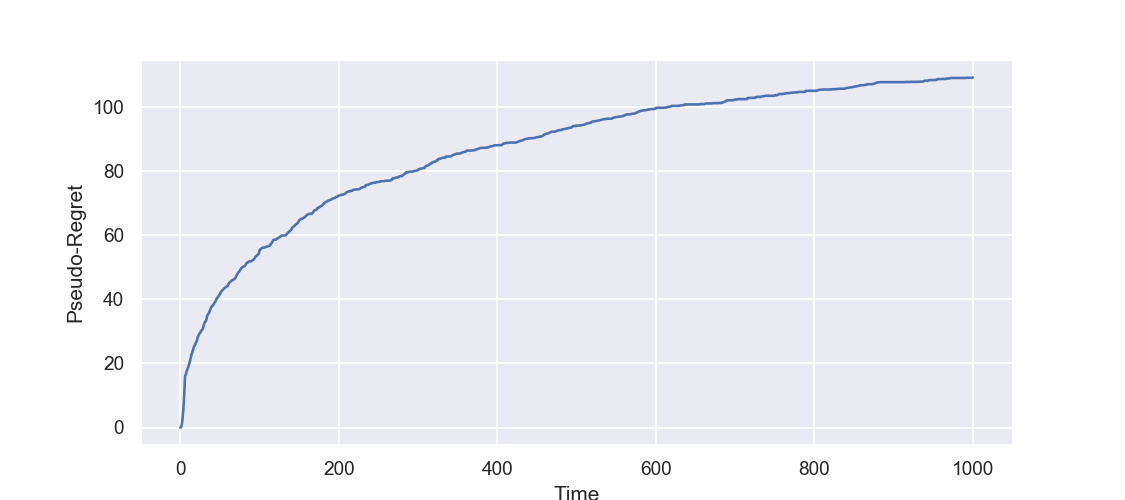

In [6]:
#Initialize Figure
plt.rcParams['figure.figsize']=[9,4]
plt.figure()

# Define the time horizon of each run, and the number of runs of each the algorithm.
T=1000
num_runs=20

#Initialize pseudo-regret
UCB_pseudo_regret=0
for runs in range(num_runs):
    #Initialize Bandit_environment
    bandit_env.initialize(make_plot=0)
    for t in range(1,T+1):
        #Choose arm using UCB algorithm
        arm,confidence_bounds=UCB_pull_arm(t, standard_deviations, bandit_env.times_pulled,bandit_env.rewards)
        
        #Pull Arm
        bandit_env.pull_arm(arm)
        
    #Keep track of pseudo-regret  
    UCB_pseudo_regret+=np.array(bandit_env.regret)
    
#Make plot
plt.plot(UCB_pseudo_regret/num_runs) 
plt.xlabel('Time')
plt.ylabel('Pseudo-Regret')
plt.show()

### Visualize Your Algorithm{-}
If you want to visualize your algorithm, you can use the following interactive demo (If it is lagging, do not worry -- this part is not graded and is just meant to build your intuition for the algorithm).

<IPython.core.display.Javascript object>


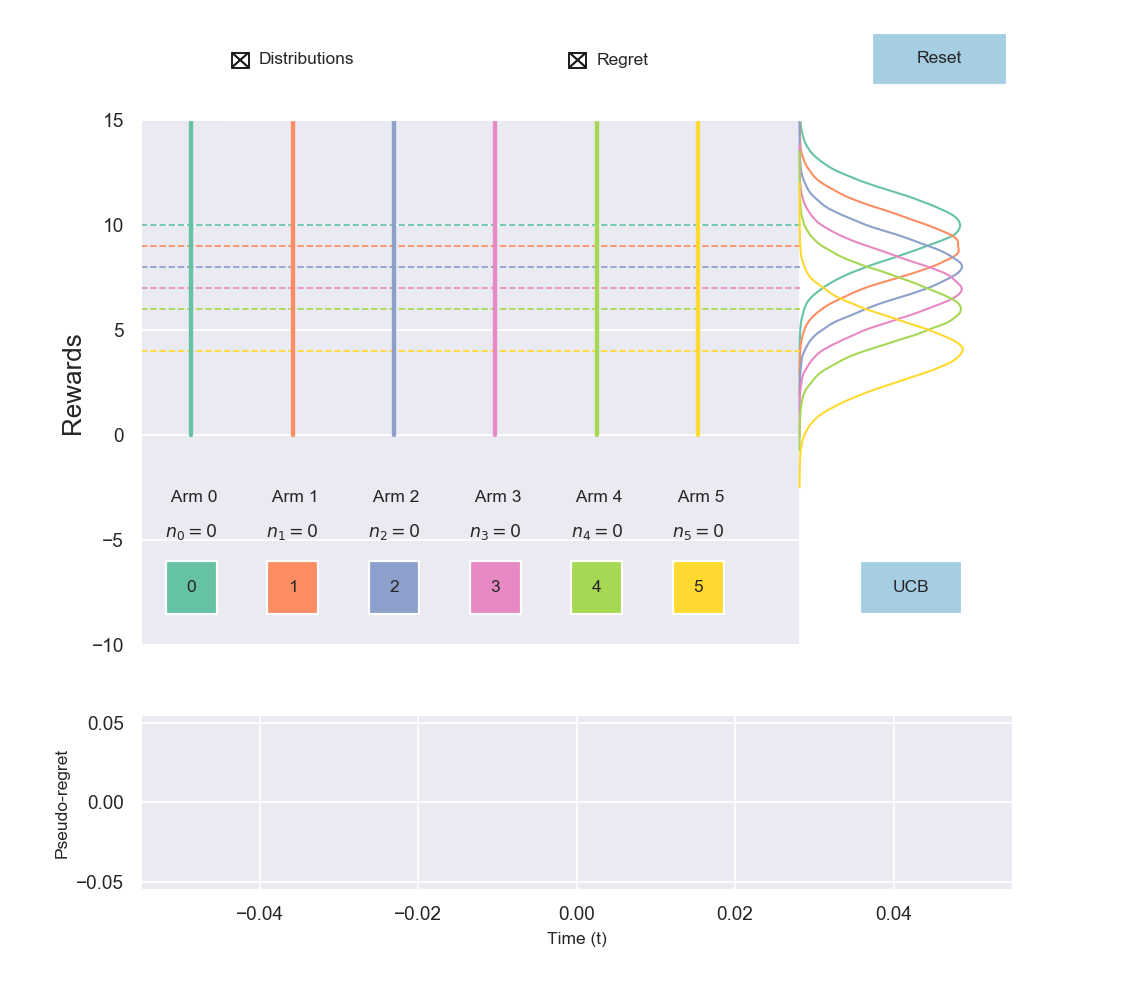

In [7]:
plt.rcParams['figure.figsize']=[9,8]

"""
Creates an interactive bandit instance with an option to test your algorithm.
    - Pull an arm by clickling on the colored button
    - Allow your algorithm to choose the arm by clicking on the ``UCB'' button in the lower right.
    - The true means of the distributions are shown with the dashed horizontal lines
    - Large solid circle is the sample mean of the arm
    - Solid vertical line is the upper confidence bound you have calculated
    - The reward distribution of each arm is shown on the right and can be toggled on/off by checking the box
    - Running Pseudo-regret is shown on the bottom and can be toggled on/off by checking the box
"""


# You may need to rerun this cell to restart the gui
alg=Interactive_UCB_Algorithm(bandit_env,UCB_pull_arm,'UCB')
alg.run_Interactive_Alg()

# Question 2. The Bayesian Approach: Thompson Sampling {-}

Now we will analyze is the Bayesian take on multi-armed bandits, known as Thompson Sampling. We begin with a prior over the mean of each arm $\mu_a \sim \pi_a$. The algorithm is described below:

**Thompson sampling algorithm**: At each round $t$
1. Draw a posterior sample for each arm: $\mu_{a,t} \sim  P_{a,t}$ for $a \in \{1,...,K\}$.
2. Choose the arm with the largest sample:
$ A_t=\underset{0 \leq a \leq K-1}{\operatorname{argmax}} \mu_{a,t}$

In other words, the probability we assign to choosing arm $a$ is the probability that it is the largest arm under the posterior on all of the data.

Since the reward distributions in this lab are Gaussians with known variance $\sigma_a^2$, we know from our investigation of conjugate priors that if we have Gaussian priors: $\mu_a\sim\mathcal{N}(\mu_{a,0},\sigma_{a,0}^2)$, and Gaussian likelihoods $X_a^{(i)}|\mu_a \sim \mathcal{N}(\mu_a, \sigma_a)$ the posterior distribution for each arm will also be a Gaussian. 

Therefore, to implement Thompson Sampling in this lab, the posterior distributions for each arm in this lab at each time $t=1,2,...$ are given by:

$$ P_{a,t}=\mathcal{N}(\hat\mu_{a,t},\hat{\sigma}_{a,t}^2)$$

where,
$$\hat{\sigma}_{a,t}^2 =\bigg(\frac{1}{\sigma_{a,0}^2}+\frac{T_a(t-1)}{\sigma_a^2}\bigg)^{-1} $$
$$ \hat\mu_{a,t}=\hat{\sigma}_{a,t}^2 \bigg( \frac{\mu_{a,0}}{\sigma_{a,0}^2}+\frac{\sum_{i=1}^{T_a(t-1)} X_{a,i}}{\sigma_a^2} \bigg)$$


## 2.a Checkpoint

What are the formulas for the posterior mean and variance when we use an improper prior $\mu_{a,0} = 0$ and $\sigma_{a,0}^2 = \infty$?

**Answer:**

$$\hat{\sigma}_{a,t}^2 = \frac{\sigma_a^2}{T_a(t-1)} $$
$$ \hat\mu_{a,t}=\frac{\sum_{i=1}^{T_a(t-1)} X_{a,i}}{T_a(t-1)}$$

## 2.b Implementing Thompson Sampling {-}

`TODO:` **Fill out the following function that implements the choice of arm for the Thompson Sampling algorithm with Gaussian arms and prior.** 

In [8]:
# TODO: complete the function
def TS_pull_arm(t,variances,times_pulled,rewards,prior_means,prior_variances):
    """ 
    Implement the choice of arm for the Thompson Sampling Algorithm when the arms and priors are Gaussians.
    
    Inputs:
        t: int, number of iteration of the bandit algorithm.
        variances: a list of length K (where K is the number of arms) of the variances
            corresponding to each arm (\sigma_a^2 in the likelihood expression above)
        times_pulled: a list of length K of the number of times each arm has been pulled.
        rewards: a list of K lists. Each of the K lists holds the samples received from pulling each arm up 
            to iteration t.
        prior_means: a list of length K with the mean of the priorsfor each arm.
        prior_mea: a list of length K with the variance of the prior for each arm.
    
    Outputs:
        arm: integer representing the arm that the TS algorithm would choose.
        posterior_samples: list of samples from the posterior used to choose the arm. 
        posterior_means: list of means of the posterior for each arm
        posterior_vars: list of variances of the posteriors of each arm
    """

    K= len(times_pulled) # TODO: fill in
    
    posterior_samples=[]
    posterior_means=[]
    posterior_vars=[]
    for arm in range(K):
        # Hint: \hat\sigma^2_{a,0} is prior_variances[arm], \sigma^2_a is variance,
        # and T_a(t-1) is times_pulled[arm] (as before).
        # Hint: \mu_{a,0} is prior_means[arm], and X_a^{(i)} is rewards[arm] (as before).
        arm_var=1/(1/(prior_variances[arm])+times_pulled[arm]/(variances[arm]))
        mean=arm_var*(prior_means[arm]/(prior_variances[arm])+np.sum(rewards[arm])/(variances[arm]))
        posterior_samples.append(np.random.normal(mean,arm_var,1))
        posterior_means.append(mean)
        posterior_vars.append(arm_var)
            
    arm = np.argmax(posterior_samples)# TODO: fill in
    
    return arm, posterior_samples, posterior_means, posterior_vars

In [9]:
# Validation tests: Do not modify
K_test = 5
times_pulled_test = [3, 5, 7, 4, 1]
prior_means_test=[8,5,7,9,6]
prior_variances_test=[2.5, 0.1, 1.6, 2.3, 1.7]
t_test = np.sum(times_pulled_test) + 1
variances_test = [0.4, 0.2, 0.1, 0.2, 0.5]
rewards_test = [[10.4, 12.6, 11], 
                [8, 13, 12, 11, 9], 
                [9, 10, 10, 8, 9.5, 10.5, 11],
                [8.3, 9.6, 7.9, 8.1],
                [8]]
test_arm, posterior_samples_test, posterior_means_test, posterior_vars_test = TS_pull_arm(t_test, 
                                                                                          variances_test, 
                                                                                          times_pulled_test, 
                                                                                          rewards_test,
                                                                                          prior_means_test,
                                                                                          prior_variances_test)
assert test_arm == 0
opt_vals_means = [11.16, 9.0, 9.69, 8.49, 7.55]
opt_vals_vars = [0.123, 0.0286, 0.014,0.049,0.386]
for a in range(K_test):
    assert (np.abs(opt_vals_means[a] - posterior_means_test[a]) <= 0.1)
    assert (np.abs(opt_vals_vars[a] - posterior_vars_test[a]) <= 0.01)
print("Test Passed!")

Test Passed!


## Thompson Sampling with Good Priors {-}
As we saw in class, the performance of Thompson Sampling can vary drastically with the quality of the prior. 

First, let us analyze the performance of Thompson Sampling when the priors reflect the correct rankings of the arms (meaning that the prior mean for arm $0$ is the highest). We will compare it to the performance of the UCB algorithm.

<IPython.core.display.Javascript object>


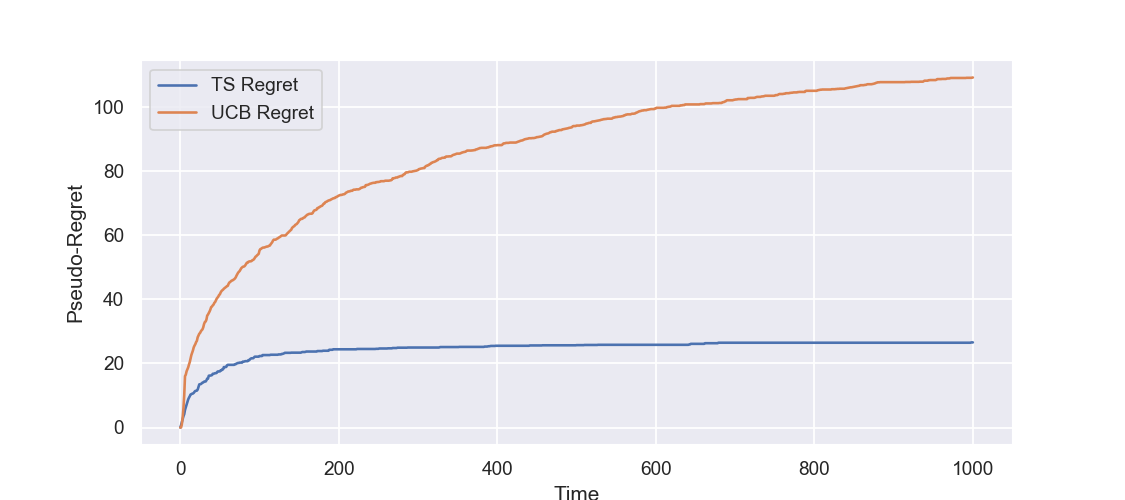

In [10]:
# No TODOs here, just run the code and inspect the plot
#Initialize Figure
plt.rcParams['figure.figsize']=[9,4]
plt.figure()

# Variance of the reward for each arm.
variance=1.5
true_variances=[variance for arm in range(len(means))]

#Define Prior Means and Variances
prior_means=[12,9,8,7,4,3]
prior_vars=[3.2,3.2,3.2,3.2,3.2,3.2]


#Initialize pseudo-regret
TS_pseudo_regret=0

for runs in range(num_runs):
    #Initialize bandit environment
    bandit_env.initialize(make_plot=0)
    for t in range(1,T+1):
        #Choose arm with Thompson Sampling
        arm,samples,means,variances=TS_pull_arm(t,true_variances,bandit_env.times_pulled,bandit_env.rewards,prior_means,prior_vars)
        
        #Pull Arm
        bandit_env.pull_arm(arm)
    
    #Keep track of regret Regret
    TS_pseudo_regret+=np.array(bandit_env.regret)
    
#Plot Thompson Sampling vs. UCB regret
plt.plot(TS_pseudo_regret/num_runs ,label='TS Regret')
plt.plot(UCB_pseudo_regret/num_runs ,label='UCB Regret')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Pseudo-Regret')
plt.show()

## Thompson Sampling with Bad Priors {-}
Now let us analyze the performance of Thompson Sampling when the priors have completely incorrect correct rankings of the arms, meaning that the prior mean for arm $0$ is the lowest.

<IPython.core.display.Javascript object>


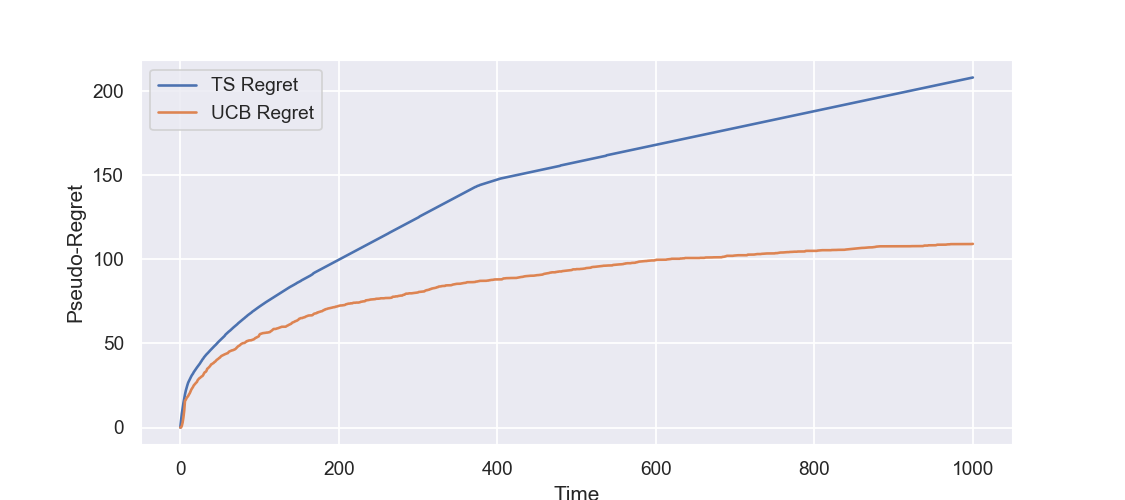

In [11]:
# No TODOs here, just run the code and inspect the plot
#Initialize Figure
plt.rcParams['figure.figsize']=[9,4]
plt.figure()

#Define prior means and standard deviations
prior_means=[2,3,4,5,6,7]
prior_vars=[3.2,3.2,3.2,3.2,3.2,3.2]

#Initialize pseudo-regret
TS_pseudo_regret=0
for runs in range(num_runs):
    #Initialize bandit environment
    bandit_env.initialize(make_plot=0)
    for t in range(1,T+1):
        #Chosoe arm with Thompson Sampling
        arm,samples,means,variances=TS_pull_arm(t,true_variances,bandit_env.times_pulled,bandit_env.rewards,prior_means,prior_vars)
        
        #Pull Arm
        bandit_env.pull_arm(arm)
    
    #Keep track of regret Regret
    TS_pseudo_regret+=np.array(bandit_env.regret)
    
#Plot Thompson Sampling vs. UCB regret
plt.plot(TS_pseudo_regret/num_runs ,label='TS Regret')
plt.plot(UCB_pseudo_regret/num_runs ,label='UCB Regret')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Pseudo-Regret')
plt.show()

## Thompson Sampling with the same prior for each arm {-}
Now let us analyze the performance of Thompson Sampling when the priors are the same for all arms.

<IPython.core.display.Javascript object>


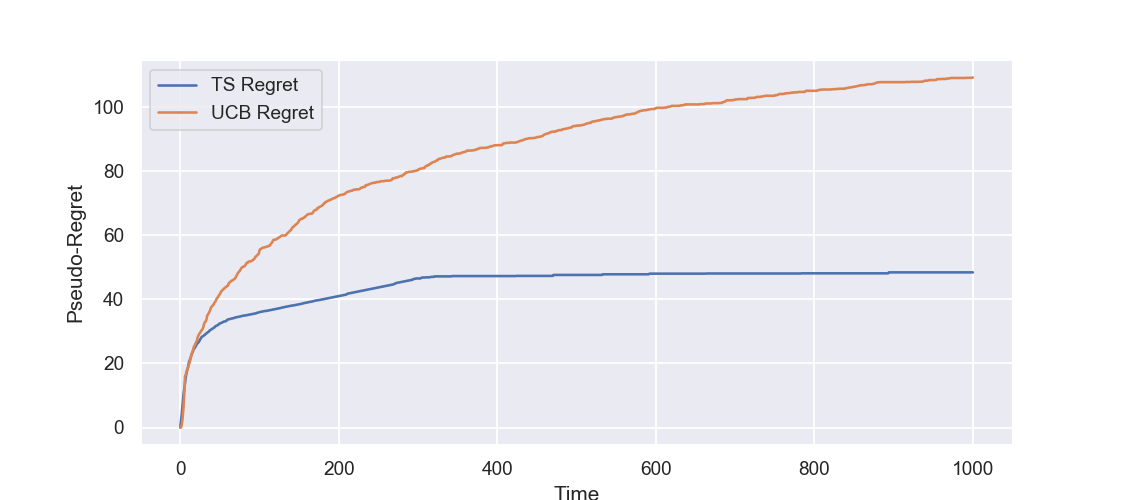

In [12]:
# No TODOs here, just run the code and inspect the plot
plt.rcParams['figure.figsize']=[9,4]
plt.figure()

#Define prior means and variances
prior_means=[8,8,8,8,8,8]
prior_vars=[2.5,2.5,2.5,2.5,2.5,2.5]

#Initialize pseudo-regret
TS_pseudo_regret=0
for runs in range(num_runs):
    #Initialize bandit environment
    bandit_env.initialize(make_plot=0)
    for t in range(1,T+1):
        #Chosoe arm with Thompson Sampling
        arm,samples,means,variances=TS_pull_arm(t,true_variances,bandit_env.times_pulled,bandit_env.rewards,prior_means,prior_vars)
        
        #Pull Arm
        bandit_env.pull_arm(arm)
    
    #Keep track of regret Regret
    TS_pseudo_regret+=np.array(bandit_env.regret)
    
#Plot Thompson Sampling vs. UCB regret
plt.plot(TS_pseudo_regret/num_runs ,label='TS Regret')
plt.plot(UCB_pseudo_regret/num_runs ,label='UCB Regret')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Pseudo-Regret')
plt.show()
# You may need to rerun this cell to restart the gui

### Visualize Your Algorithm {-}
If you want to visualize your algorithm, you can use the following interactive demo (If it is lagging, do not worry this part is not graded and is meant to build your intuition for the algorithm):

<IPython.core.display.Javascript object>


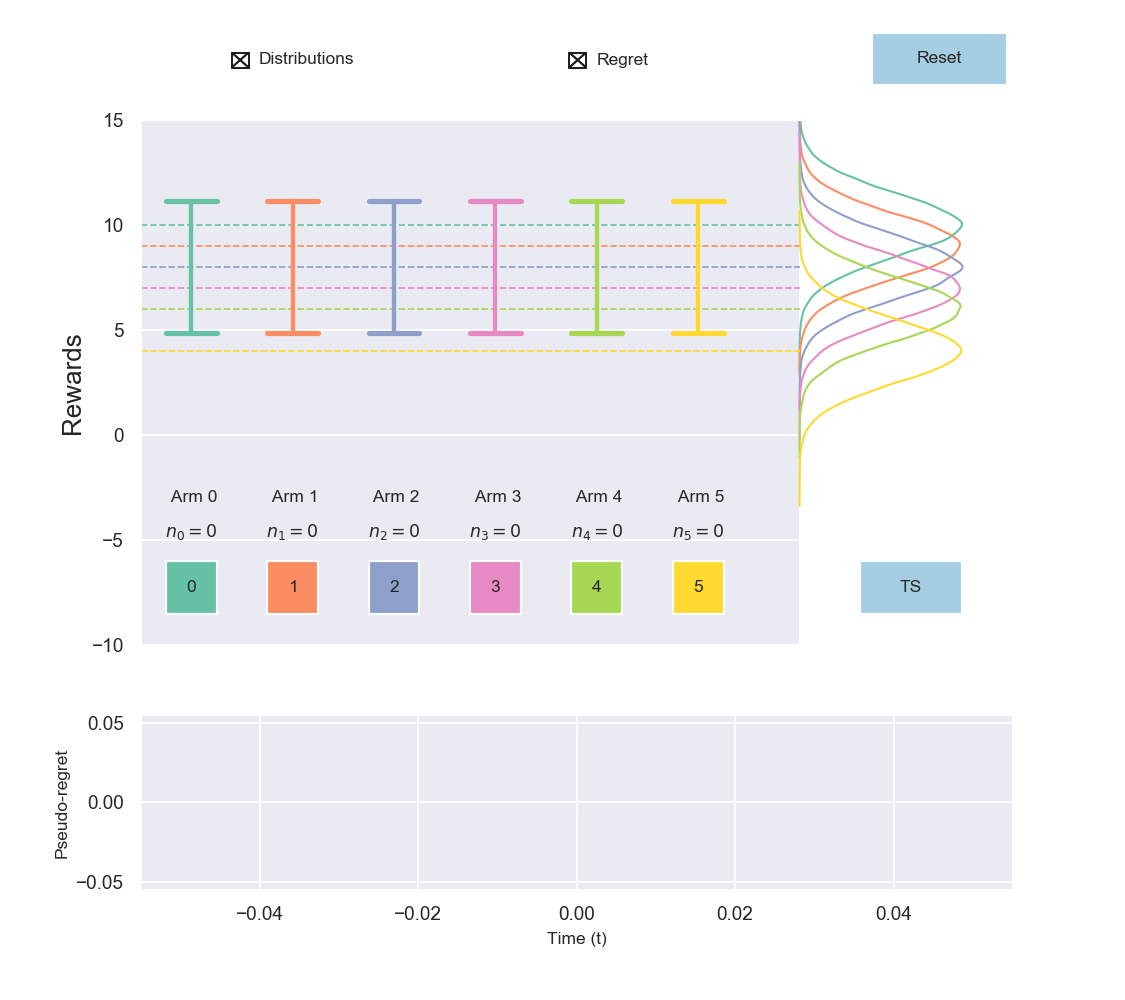

In [13]:
plt.rcParams['figure.figsize']=[9,8]

"""
Creates an interactive bandit instance with an option to test your algorithm.
    - Pull an arm by clickling on the colored button.
    - Allow your algorithm to choose the arm by clicking on the ``TS'' button in the lower right.
    - The true means of the distributions are shown with the dashed horizontal lines.
    - Large solid circle is the sample mean of the rewards for the arm.
    - Solid vertical line shows the 95% credible interval for the arm.
    - The reward distribution of each arm is shown on the right and can be toggled on/off by checking the box.
    - Running Pseudo-regret is shown on the bottom and can be toggled on/off by checking the box.
"""

#Define prior means and variances
prior_means=[8,8,8,8,8,8]
prior_vars=[2.5,2.5,2.5,2.5,2.5,2.5]

# You may need to rerun this cell to restart the gui
alg=Interactive_TS_Algorithm(bandit_env,TS_pull_arm,'TS',prior_means,prior_vars)
alg.run_Interactive_Alg()

## Question 3. Pros and Cons of UCB and Thompson Sampling {-}

In the following cell, write a few sentences comparing and contrasting UCB and Thompson Sampling. What are some pros and cons of UCB and of Thompson Sampling?

...

- UCB:
    - UBC exhibits logarithmic regret regardless of the means and variances of the arms.
    - UCB is a frequentist technique and thus does not require setting up priors
- TS:
    - TS can perform much better than UCB with a good choice of prior, but can perform much poorly if the chosen prior is bad.

Yay, you've made it to the end of Lab 8!


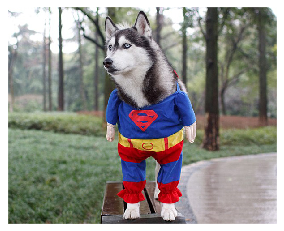

In [14]:
%matplotlib inline
import matplotlib.image as mpimg
img = mpimg.imread('husky.jpg')
imgplot = plt.imshow(img)
imgplot.axes.get_xaxis().set_visible(False)
imgplot.axes.get_yaxis().set_visible(False)
print("Yay, you've made it to the end of Lab 8!")
plt.show()